In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

model_dir = './models/'
data_dir = './data/'
train_json_path = './data/KorQuAD_v1.0_train.json'
dev_json_path = './data/KorQuAD_v1.0_dev.json'


In [2]:
# 띄어쓰기 검출
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

# 띄어쓰기 단위 정보관리
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    return word_tokens, char_to_word

# 토큰화 함수
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        # word_to_token : 음절
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)


In [3]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        # tqdm : progress bar
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")


In [4]:
# 이상치 확인
def analysis_data(cnt_sentence, str_name, bins, range_, facecolor = 'r', label = ''):
    plt.figure(figsize=(8, 4))
    # histogram 선언
    plt.hist(cnt_sentence, bins=bins, range=range_, facecolor=facecolor, label=label)
    # 그래프 제목
    plt.title('Count of ' + str_name)
    # 그래프 x 축 라벨
    plt.xlabel('Number of ' + str_name)
    # 그래프 y 축 라벨
    plt.ylabel('Count of ' + str_name)
    plt.show()
    
    # 데이터 길이
    percentile25 = np.percentile(cnt_sentence, 25)
    percentile50 = np.percentile(cnt_sentence, 50)
    percentile75 = np.percentile(cnt_sentence, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f"{str_name} 길이 최대:    {np.max(cnt_sentence):4d}")
    print(f"{str_name} 길이 최소:    {np.min(cnt_sentence):4d}")
    print(f"{str_name} 길이 평균:    {np.mean(cnt_sentence):7.2f}")
    print(f"{str_name} 길이 표준편차: {np.std(cnt_sentence):7.2f}")
    print(f"{str_name} 25/100분위:  {percentile25:7.2f}")
    print(f"{str_name} 50/100분위:  {percentile50:7.2f}")
    print(f"{str_name} 75/100분위:  {percentile75:7.2f}")
    print(f"{str_name} IQR:        {percentileIQR:7.2f}")
    print(f"{str_name} MAX/100분위: {percentileMAX:7.2f}")
    
    plt.figure(figsize=(4, 6))
    # 박스플롯 생성
    plt.boxplot(cnt_sentence, labels=['token counts'], showmeans=True)
    plt.show()


In [5]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')
    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [6]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


# 데이터 준비

In [7]:
# 데이터 확인
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(model_dir, 'ko_32000.model'))

# 훈련데이터 
with open(train_json_path) as f:
    train_json = json.load(f)

# 검증데이터
with open(dev_json_path) as f:
    dev_json = json.load(f)


In [8]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")


  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

# 데이터 분석

In [9]:
questions = []
contexts = []
token_starts = []
path_data = data_dir + '/korquad_train.json'

with open(path_data) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
    
# token count
train_question_counts = [len(question) for question in questions]
train_context_counts = [len(context) for context in contexts]
train_answer_starts = token_starts

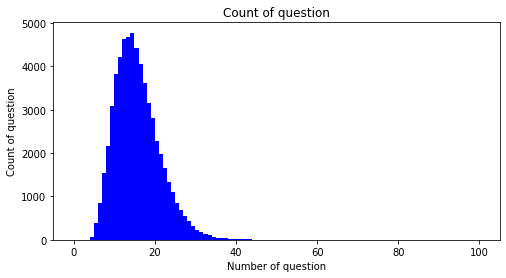

question 길이 최대:      58
question 길이 최소:       3
question 길이 평균:      15.25
question 길이 표준편차:    5.50
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50


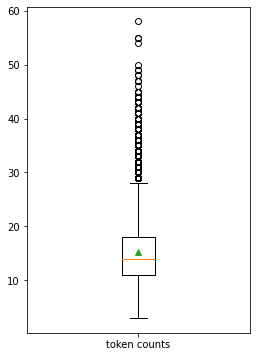

In [10]:
analysis_data(train_question_counts, 'question', 100, [0, 100], 'b', 'train')


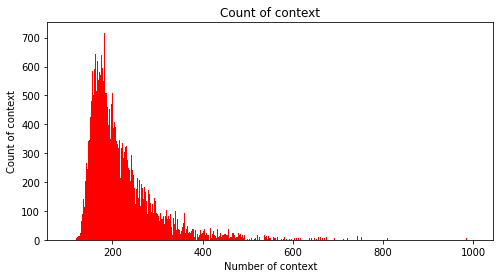

context 길이 최대:    4816
context 길이 최소:     108
context 길이 평균:     222.84
context 길이 표준편차:   97.68
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   248.00
context IQR:          79.00
context MAX/100분위:  366.50


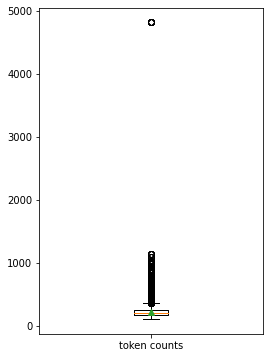

In [11]:
analysis_data(train_context_counts, 'context', 900, [100, 1000], 'r', 'train')


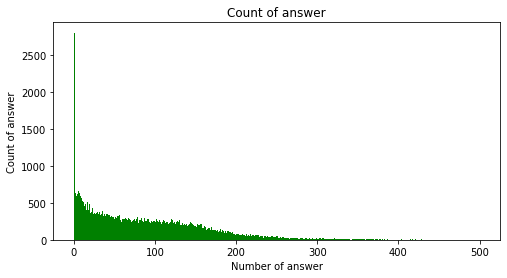

answer 길이 최대:    1124
answer 길이 최소:       0
answer 길이 평균:      89.01
answer 길이 표준편차:   78.21
answer 25/100분위:    25.00
answer 50/100분위:    74.00
answer 75/100분위:   134.00
answer IQR:         109.00
answer MAX/100분위:  297.50


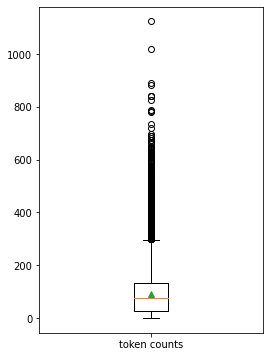

In [12]:
analysis_data(train_answer_starts, 'answer', 500, [0, 500], 'g', 'train')


# 전처리 데이터 로드

In [13]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [14]:
args = Config({
    # context_len에 관여
    'max_seq_length': 384,
    # question_len에 관여
    'max_query_length': 64,
})

# train data load
train_inputs, train_labels = load_data(args, train_json)

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)


Loading ...: 0it [00:00, ?it/s]

n_discard: 430


Loading ...: 0it [00:00, ?it/s]

n_discard: 78


# LSTM

In [15]:
def build_model_lstm(n_vocab, n_seq, d_model):
    tokens = tf.keras.layers.Input((None,), name='tokens')
    segments = tf.keras.layers.Input((None,), name='segments')

    hidden = tf.keras.layers.Embedding(n_vocab, d_model)(tokens) + tf.keras.layers.Embedding(2, d_model)(segments) # (bs, n_seq, d_model)

    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.LSTM(d_model, return_sequences=True)(hidden)  # (bs, n_seq, d_model)
    hidden = tf.keras.layers.Dense(2)(hidden) # (bs, n_seq, 2)
    start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)
    start_logits = tf.squeeze(start_logits, axis=-1)  # (bs, n_seq)
    start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)
    end_logits = tf.squeeze(end_logits, axis=-1)  # (bs, n_seq)
    end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

    model = tf.keras.Model(inputs=(tokens, segments), outputs=(start_outputs, end_outputs))
    return model

In [16]:
model_lstm = build_model_lstm(n_vocab=len(vocab), n_seq=512, d_model=512)
tf.keras.utils.plot_model(model_lstm, 'model.png', show_shapes=True)

model_lstm.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), metrics=["accuracy"])


In [17]:
# 학습
# early stopping
early_stopping_lstm = tf.keras.callbacks.EarlyStopping(monitor='val_start_accuracy', patience=3)
# save weights
save_weights_lstm = tf.keras.callbacks.ModelCheckpoint(os.path.join(data_dir, "korquad_lstm.hdf5"), monitor='val_start_accuracy', verbose=1, save_best_only=True, mode='max', save_freq='epoch', save_weights_only=True)

history_lstm = model_lstm.fit(train_inputs, train_labels, epochs=10, batch_size=128, validation_data=(dev_inputs, dev_labels), callbacks=[early_stopping_lstm, save_weights_lstm])


Epoch 1/10
469/469 [==============================] - 223s 428ms/step - loss: 9.1251 - start_loss: 4.4190 - end_loss: 4.7061 - start_accuracy: 0.0685 - end_accuracy: 0.0525 - val_loss: 8.2436 - val_start_loss: 3.9173 - val_end_loss: 4.3263 - val_start_accuracy: 0.0920 - val_end_accuracy: 0.0795

Epoch 00001: val_start_accuracy improved from -inf to 0.09199, saving model to ./data/korquad_lstm.hdf5
Epoch 2/10
469/469 [==============================] - 210s 448ms/step - loss: 7.2977 - start_loss: 3.4786 - end_loss: 3.8191 - start_accuracy: 0.1255 - end_accuracy: 0.1170 - val_loss: 8.1883 - val_start_loss: 3.8890 - val_end_loss: 4.2992 - val_start_accuracy: 0.0983 - val_end_accuracy: 0.0751

Epoch 00002: val_start_accuracy improved from 0.09199 to 0.09831, saving model to ./data/korquad_lstm.hdf5
Epoch 3/10
469/469 [==============================] - 213s 455ms/step - loss: 6.6975 - start_loss: 3.2152 - end_loss: 3.4823 - start_accuracy: 0.1545 - end_accuracy: 0.1490 - val_loss: 8.6158 - v

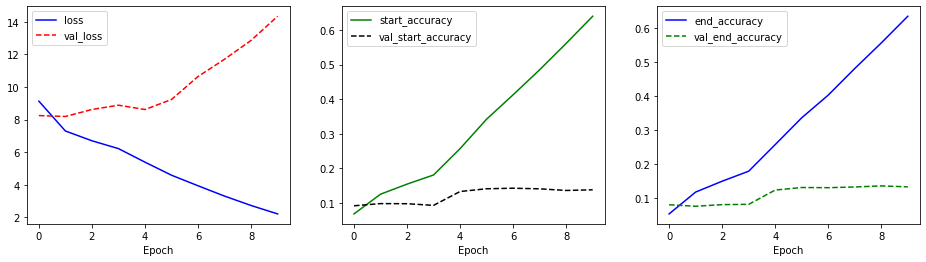

In [18]:
# 시각화
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(history_lstm.history['loss'], 'b-', label='loss')
plt.plot(history_lstm.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_lstm.history['start_accuracy'], 'g-', label='start_accuracy')
plt.plot(history_lstm.history['val_start_accuracy'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_lstm.history['end_accuracy'], 'b-', label='end_accuracy')
plt.plot(history_lstm.history['val_end_accuracy'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# BERT

In [24]:
#  BERT 모델 
# Transformer에서 사용되던 position embedding과 동일
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [25]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [26]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [27]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [29]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [31]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [32]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [33]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [34]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [35]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [36]:
# BERT-base(110M parameters) : 12-layer, 768-hidden, 12-heads
# BERT-large (336M parameters) : 24-layer, 1024-hidden, 16-heads
    
# Our Tiny Bert(29M parameters) : 6-layer, 512-hidden, 8-heads

In [37]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [38]:
model = BERT4KorQuAD(config)

In [39]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0

HEADER_HISTORY = ('loss', 'start_loss', 'end_loss', 'start_acc', 'end_acc', 
                  'val_loss', 'val_start_loss', 'val_end_loss', 'val_start_acc', 'val_end_acc')
result_history = {}
for header in HEADER_HISTORY:
    result_history[header] = []

for epoch in range(10):
    start_loss, end_loss, start_acc, end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    result_history['loss'].append(start_loss+end_loss)
    result_history['start_loss'].append(start_loss)
    result_history['end_loss'].append(end_loss)
    result_history['start_acc'].append (start_acc)
    result_history['end_acc'].append(end_acc)
    
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    result_history['val_loss'].append(start_loss+end_loss)
    result_history['val_start_loss'].append(start_loss)
    result_history['val_end_loss'].append(end_loss)
    result_history['val_start_acc'].append (start_acc)
    result_history['val_end_acc'].append(end_acc)
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.9501, 5.9643, acc: 0.0033, 0.0067
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.3723, 5.4024, acc: 0.0142, 0.0067
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.5003, 5.7537, acc: 0.0114, 0.0077


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.3745, 5.3686, acc: 0.0047, 0.0026
early stopping


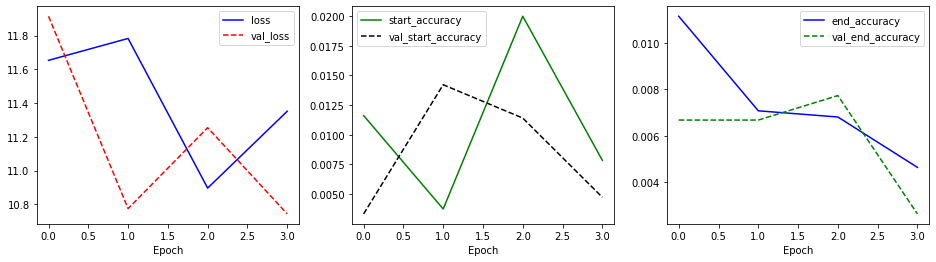

In [40]:
# 시각화
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(result_history['loss'], 'b-', label='loss')
plt.plot(result_history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(result_history['start_acc'], 'g-', label='start_accuracy')
plt.plot(result_history['val_start_acc'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(result_history['end_acc'], 'b-', label='end_accuracy')
plt.plot(result_history['val_end_acc'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [41]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [42]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

46
질문 :  1규빗을 미터법으로 환산하면 얼마인가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층으로 만들어져 있었다. 선체(船體)는 고페르나무(잣나무)로 되고 안쪽에는 역청(아스팔트와 비슷한 성분)을 칠하여 굳혔다고 기록하고 있다.
정답 :  45~46cm
예측 :  하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8 

84
질문 :  목재 선박의 배수량 한계는?
지문 :  창조과학회에서는 또한 노아의 

# Pretrained model의 활용

## STEP 1. pretrained model 로딩하기

In [43]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_74 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


## STEP 2. pretrained model finetune 하기

In [44]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0

result_history = {}
for header in HEADER_HISTORY:
    result_history[header] = []

for epoch in range(10):
    start_loss, end_loss, start_acc, end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    result_history['loss'].append(start_loss+end_loss)
    result_history['start_loss'].append(start_loss)
    result_history['end_loss'].append(end_loss)
    result_history['start_acc'].append (start_acc)
    result_history['end_acc'].append(end_acc)
    
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    result_history['val_loss'].append(start_loss+end_loss)
    result_history['val_start_loss'].append(start_loss)
    result_history['val_end_loss'].append(end_loss)
    result_history['val_start_acc'].append (start_acc)
    result_history['val_end_acc'].append(end_acc)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 2 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.9229, 2.1274, acc: 0.5142, 0.4954
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.7017, 1.9377, acc: 0.5562, 0.5291
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8905, 2.1369, acc: 0.5557, 0.5111


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 1.9435, 2.1944, acc: 0.5495, 0.5118
early stopping


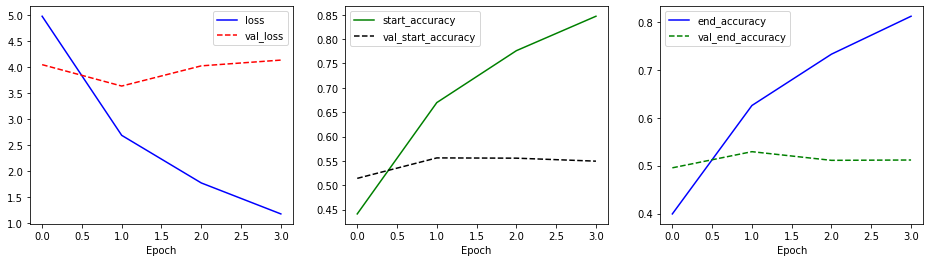

In [45]:
# 시각화
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(result_history['loss'], 'b-', label='loss')
plt.plot(result_history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(result_history['start_acc'], 'g-', label='start_accuracy')
plt.plot(result_history['val_start_acc'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(result_history['end_acc'], 'b-', label='end_accuracy')
plt.plot(result_history['val_end_acc'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## STEP 3. Inference 수행하기

In [46]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [47]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

34
질문 :  알렉산더 헤이그는 레이건의 조언자들을 무엇이라고 묘사하였는가?
지문 :  그의 편에 헤이그는 지구촌의 논점들의 국내적 정치 노력들에 관해서만 근심한 레이건의 가까운 조언자들을 "외교 정책의 아마추어"로 묘사하였다. 1982년 6월 25일 결국적으로 온 그의 국무장관으로서 사임은 불가능한 상황이 된 것을 끝냈다. 헤이그는 개인적 생활로 돌아갔다가 1988년 대통령 선거를 위한 공화당 후보직을 안정시키는 시도를 하는 데 충분하게 정계로 돌아갔으나 후보직을 이기는 데 성원을 가지지 않았다. 그는 외교 정책 논쟁들에 연설자로서 활동적으로 남아있었으나 그의 전념은 정치에서 개인적 생활로 옮겨졌다. 그는 Worldwide Associates Inc.의 국제적 상담 회사에 의하여 기용되었고, 그 기구의 의장과 회장이 되었다.
정답 :  외교 정책의 아마추어
예측 :  "외교 정책의 아마추어"로 

35
질문 :  헤이그가 사적생활을 하다가 정계로 돌아갔던 해는 언제인가?
지문 :  그의 편에 헤이그는 지구촌의 논점들의 국내적 정치 노력들에 관해서만 근심한 레이건의 가까운 조언자들을 "외교 정책의 아마추어"로 묘사하였다. 1982년 6월 25일 결국적으로 온 그의 국무장관으로서 사임은 불가능한 상황이 된 것을 끝냈다. 헤이그는 개인적 생활로 돌아갔다가 1988년 대통령 선거를 위한 공화당 후보직을 안정시키는 시도를 하는 데 충분하게 정계로 돌아갔으나 후보직을 이기는 데 성원을 가지지 않았다. 그는 외교 정책 논쟁들에 연설자로서 활동적으로 남아있었으나 그의 전념은 정치에서 개인적 생활로 옮겨졌다. 그는 Worldwide Associates Inc.의 국제적 상담 회사에 의하여 기용되었고, 그 기구의 의장과 회장이 되었다.
정답 :  1988년
예측 :  1988년 

37
질문 :  헤이그가 정계로 돌아간 년도는 몇년도입니까?
지문 :  그의 편에 헤이그는 지구촌의 논점들의 국내적 정치 노력들에 관해서만 근심한 레이건의 가까운 조언자들을 "외교 정책의 아마추어

62
질문 :  유사지질학자들이 노아의 홍수를 증명하기 위해 성경 이외에 근거라고 주장한 것들은?
지문 :  역사학과 과학의 발달이 더뎠던 고대사회에서는, 성경이 단순한 교리적인 부분 뿐 아니라 역사책으로서의 권위도 높았기에 노아의 방주를 역사적인 존재로서 다루고 있었다. 이는 제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학인 홍수지질학과 같은 것에 영향을 주었으며, 과거 신학에서는 이러한 근본주의적 해석을 받아들여 역사와 사회적인 모든 부분에 있어 성경을 교과서로 채택할 것을 촉구했다. 이러한 홍수지질학을 주장했던 유사지질학자들은 성경에 나오는 노아의 홍수가 어딘가에 그 흔적이 남아 있을것이라고 주장하며 노아의 방주를 찾기 위한 노력을 했다고 주장한다. 이들은 같은 메소포타미아 지방의 신화인 이슬람교 경전이나 길가메쉬 서사시등의 신화를 들어서 이를 근거라고 주장하기도 했다. 그러나 이러한 전통적 근본주의적 시각은 과거에는 상당히 힘을 얻었으나, 역사학과 과학의 발달에 따라 힘을 잃게 되었고, 홍수지질학은 유사과학으로서 남게 되었다. 현대에는 뒤의 실존논란에서 다루는 것처럼 이러한 근본주의적 해석은 비과학적인 해석으로 여기는 것이 일반적이지만, 남침례교로 대표되는 극보수주의계열 기독교에서는 아직도 이것이 받아들여지고 있다.
정답 :  이슬람교 경전이나 길가메쉬 서사시
예측 :  방주를 찾기 위한 노력을 했다고 주장한다. 이들은 같은 메소포타미아 지방의 신화인 이슬람교 경전이나 길가메쉬 서사시등의 

64
질문 :  한국에서 홍수지질학적 주장들을 내어 놓고 있는 집단은?
지문 :  물론 노아의 방주가 신학과 신앙에서 중요한 영향을 차지하는 것은 사실이나, 현재 노아의 방주가 역사적으로 실존한다는 주장은 그 증거가 존재하지 않기에 관련 학계로부터 전혀 인정받지 못하고 있으며 그 실존과 안정성에 대한 수많은 논란이 있다. 한국창조과학회 등에서는 제칠일안식교를 기반으로 한 홍수지질학적 주장들을을 내어 놓고 있지만, 사실과 다른 근거들을 바탕으로 주장하므로 신뢰

81
질문 :  노아의 방주 안정성을 실험하기 위한 연구가 있다고 주장하는 단체는?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고 주장하지만, 이와는 달리 노아의 방주는 항해가 불가능한 설계에 가깝다. 실제로 창조과학에서 주장하는 방주의 크기와 철제 부품을 사용하지 않은 목재 선박 중에서 가장 큰 수준의 선박들을 비교하면 배수량이 두배 이상 차이난다. 그리고 목재 선박은 강도 상의 문제 때문에 통상 길이 100m, 배수량 2000톤 정도가 한계로 여겨져 왔다. 창조과학회에서는 노아의 방주의 안정성을 실험하기 위한 연구가 있다고 주장하기도 하나, 그 자체의 불합리성에 대한 비판을 받고 있으며, 관련 주요 연구자는 지질학 석사학위, 생물학 학사학위를 가진 초등학교 교사로서, 주류 학계의 학회나 저널 등에 발표한 적이 없으며 또한 정당한 피어 리뷰에 의해 검증받지 않았다.
정답 :  창조과학회
예측 :  창조과학회 

83
질문 :  목재로 만들어진 선박은 강도 상의 통상 길이 몇m가 한계인가?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고 주장하지만, 이와는 달리 노아의 방주는 항해가 불가능한 설계에 가깝다. 실제로 창조과학에서 주장하는 방주의 크기와 철제 부품을 사용하지 않은 목재 선박 중에서 가장 큰 수준의 선박들을 비교하면 배수량이 두배 이상 차이난다. 그리고 목재 선박은 강도 상의 문제 때문에 통상 길이 100m, 배수량 2000톤 정도가 한계로 여겨져 왔다. 창조과학회에서는 노아의 방주의 안정성을 실험하기 위한 연구가 있다고 주장하기도 하나, 그 자체의 불합리성에 대한 비판을 받고 있으며, 관련 주요 연구자는 지질학 석사학위, 생물학 학사학위를 가진 초등학교 교사로서, 주류 학계의 학회나 저널 등에 발표한 적이 없으며 또한 정당한 피어 리뷰에 의해 검증받지 않았다.
정답 :  100m
예측 :  100m 

84
질문 :  목재 선박의 배수량 한계는?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고

## STEP 4. 학습 경과 시각화 비교 분석

## LSTM 시각화, 결과

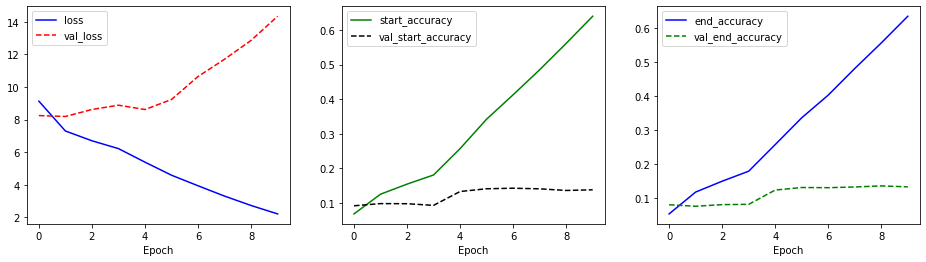

In [18]:
# 시각화
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(history_lstm.history['loss'], 'b-', label='loss')
plt.plot(history_lstm.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_lstm.history['start_accuracy'], 'g-', label='start_accuracy')
plt.plot(history_lstm.history['val_start_accuracy'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_lstm.history['end_accuracy'], 'b-', label='end_accuracy')
plt.plot(history_lstm.history['val_end_accuracy'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## BERT 시각화, 결과

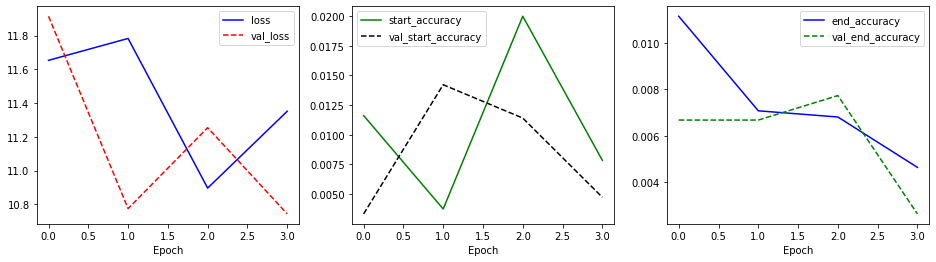

In [40]:
# 시각화
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(result_history['loss'], 'b-', label='loss')
plt.plot(result_history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(result_history['start_acc'], 'g-', label='start_accuracy')
plt.plot(result_history['val_start_acc'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(result_history['end_acc'], 'b-', label='end_accuracy')
plt.plot(result_history['val_end_acc'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [42]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

46
질문 :  1규빗을 미터법으로 환산하면 얼마인가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층으로 만들어져 있었다. 선체(船體)는 고페르나무(잣나무)로 되고 안쪽에는 역청(아스팔트와 비슷한 성분)을 칠하여 굳혔다고 기록하고 있다.
정답 :  45~46cm
예측 :  하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8 

84
질문 :  목재 선박의 배수량 한계는?
지문 :  창조과학회에서는 또한 노아의 

## BERT(pretrained) 시각화, 결과

- accuracy가 안정적으로 증가
- 이전 학습에 비해 높아진 accuracy

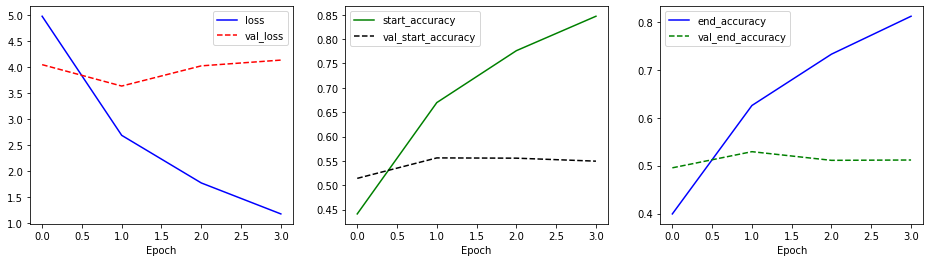

In [45]:
# 시각화
# training result
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(result_history['loss'], 'b-', label='loss')
plt.plot(result_history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(result_history['start_acc'], 'g-', label='start_accuracy')
plt.plot(result_history['val_start_acc'], 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(result_history['end_acc'], 'b-', label='end_accuracy')
plt.plot(result_history['val_end_acc'], 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [47]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

34
질문 :  알렉산더 헤이그는 레이건의 조언자들을 무엇이라고 묘사하였는가?
지문 :  그의 편에 헤이그는 지구촌의 논점들의 국내적 정치 노력들에 관해서만 근심한 레이건의 가까운 조언자들을 "외교 정책의 아마추어"로 묘사하였다. 1982년 6월 25일 결국적으로 온 그의 국무장관으로서 사임은 불가능한 상황이 된 것을 끝냈다. 헤이그는 개인적 생활로 돌아갔다가 1988년 대통령 선거를 위한 공화당 후보직을 안정시키는 시도를 하는 데 충분하게 정계로 돌아갔으나 후보직을 이기는 데 성원을 가지지 않았다. 그는 외교 정책 논쟁들에 연설자로서 활동적으로 남아있었으나 그의 전념은 정치에서 개인적 생활로 옮겨졌다. 그는 Worldwide Associates Inc.의 국제적 상담 회사에 의하여 기용되었고, 그 기구의 의장과 회장이 되었다.
정답 :  외교 정책의 아마추어
예측 :  "외교 정책의 아마추어"로 

35
질문 :  헤이그가 사적생활을 하다가 정계로 돌아갔던 해는 언제인가?
지문 :  그의 편에 헤이그는 지구촌의 논점들의 국내적 정치 노력들에 관해서만 근심한 레이건의 가까운 조언자들을 "외교 정책의 아마추어"로 묘사하였다. 1982년 6월 25일 결국적으로 온 그의 국무장관으로서 사임은 불가능한 상황이 된 것을 끝냈다. 헤이그는 개인적 생활로 돌아갔다가 1988년 대통령 선거를 위한 공화당 후보직을 안정시키는 시도를 하는 데 충분하게 정계로 돌아갔으나 후보직을 이기는 데 성원을 가지지 않았다. 그는 외교 정책 논쟁들에 연설자로서 활동적으로 남아있었으나 그의 전념은 정치에서 개인적 생활로 옮겨졌다. 그는 Worldwide Associates Inc.의 국제적 상담 회사에 의하여 기용되었고, 그 기구의 의장과 회장이 되었다.
정답 :  1988년
예측 :  1988년 

37
질문 :  헤이그가 정계로 돌아간 년도는 몇년도입니까?
지문 :  그의 편에 헤이그는 지구촌의 논점들의 국내적 정치 노력들에 관해서만 근심한 레이건의 가까운 조언자들을 "외교 정책의 아마추어

62
질문 :  유사지질학자들이 노아의 홍수를 증명하기 위해 성경 이외에 근거라고 주장한 것들은?
지문 :  역사학과 과학의 발달이 더뎠던 고대사회에서는, 성경이 단순한 교리적인 부분 뿐 아니라 역사책으로서의 권위도 높았기에 노아의 방주를 역사적인 존재로서 다루고 있었다. 이는 제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학인 홍수지질학과 같은 것에 영향을 주었으며, 과거 신학에서는 이러한 근본주의적 해석을 받아들여 역사와 사회적인 모든 부분에 있어 성경을 교과서로 채택할 것을 촉구했다. 이러한 홍수지질학을 주장했던 유사지질학자들은 성경에 나오는 노아의 홍수가 어딘가에 그 흔적이 남아 있을것이라고 주장하며 노아의 방주를 찾기 위한 노력을 했다고 주장한다. 이들은 같은 메소포타미아 지방의 신화인 이슬람교 경전이나 길가메쉬 서사시등의 신화를 들어서 이를 근거라고 주장하기도 했다. 그러나 이러한 전통적 근본주의적 시각은 과거에는 상당히 힘을 얻었으나, 역사학과 과학의 발달에 따라 힘을 잃게 되었고, 홍수지질학은 유사과학으로서 남게 되었다. 현대에는 뒤의 실존논란에서 다루는 것처럼 이러한 근본주의적 해석은 비과학적인 해석으로 여기는 것이 일반적이지만, 남침례교로 대표되는 극보수주의계열 기독교에서는 아직도 이것이 받아들여지고 있다.
정답 :  이슬람교 경전이나 길가메쉬 서사시
예측 :  방주를 찾기 위한 노력을 했다고 주장한다. 이들은 같은 메소포타미아 지방의 신화인 이슬람교 경전이나 길가메쉬 서사시등의 

64
질문 :  한국에서 홍수지질학적 주장들을 내어 놓고 있는 집단은?
지문 :  물론 노아의 방주가 신학과 신앙에서 중요한 영향을 차지하는 것은 사실이나, 현재 노아의 방주가 역사적으로 실존한다는 주장은 그 증거가 존재하지 않기에 관련 학계로부터 전혀 인정받지 못하고 있으며 그 실존과 안정성에 대한 수많은 논란이 있다. 한국창조과학회 등에서는 제칠일안식교를 기반으로 한 홍수지질학적 주장들을을 내어 놓고 있지만, 사실과 다른 근거들을 바탕으로 주장하므로 신뢰

81
질문 :  노아의 방주 안정성을 실험하기 위한 연구가 있다고 주장하는 단체는?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고 주장하지만, 이와는 달리 노아의 방주는 항해가 불가능한 설계에 가깝다. 실제로 창조과학에서 주장하는 방주의 크기와 철제 부품을 사용하지 않은 목재 선박 중에서 가장 큰 수준의 선박들을 비교하면 배수량이 두배 이상 차이난다. 그리고 목재 선박은 강도 상의 문제 때문에 통상 길이 100m, 배수량 2000톤 정도가 한계로 여겨져 왔다. 창조과학회에서는 노아의 방주의 안정성을 실험하기 위한 연구가 있다고 주장하기도 하나, 그 자체의 불합리성에 대한 비판을 받고 있으며, 관련 주요 연구자는 지질학 석사학위, 생물학 학사학위를 가진 초등학교 교사로서, 주류 학계의 학회나 저널 등에 발표한 적이 없으며 또한 정당한 피어 리뷰에 의해 검증받지 않았다.
정답 :  창조과학회
예측 :  창조과학회 

83
질문 :  목재로 만들어진 선박은 강도 상의 통상 길이 몇m가 한계인가?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고 주장하지만, 이와는 달리 노아의 방주는 항해가 불가능한 설계에 가깝다. 실제로 창조과학에서 주장하는 방주의 크기와 철제 부품을 사용하지 않은 목재 선박 중에서 가장 큰 수준의 선박들을 비교하면 배수량이 두배 이상 차이난다. 그리고 목재 선박은 강도 상의 문제 때문에 통상 길이 100m, 배수량 2000톤 정도가 한계로 여겨져 왔다. 창조과학회에서는 노아의 방주의 안정성을 실험하기 위한 연구가 있다고 주장하기도 하나, 그 자체의 불합리성에 대한 비판을 받고 있으며, 관련 주요 연구자는 지질학 석사학위, 생물학 학사학위를 가진 초등학교 교사로서, 주류 학계의 학회나 저널 등에 발표한 적이 없으며 또한 정당한 피어 리뷰에 의해 검증받지 않았다.
정답 :  100m
예측 :  100m 

84
질문 :  목재 선박의 배수량 한계는?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고